<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/Election_in_the_run_with_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings! 

You might be here because you think


*   Betting markets are far more efficient then Nate Silver or G. Elliott Morris (really can't help you if you insist otherwise - perhaps G. Elliott will offer you 19/1 on Trump LOL) 
*   Betting markets still requires some interpretation, because many punters are so lazy they don't even run simulations

This notebook provides you with a simple interpretation of market implied state electoral college probabilities, nothing more. It can be used to compute things like the market implied correlation between states, using a very simple correlation model. That may, or may not, provide you with a new perspective on the markets or a lens as to their degree of internal consistency.

In using this, rather than the groovy graphics at 538, you are taking a stand against the ridiculous celebritization of statistics and journalistic group-think. 

```
# This is formatted as code
```



In [68]:
import numpy as np
from pprint import pprint
import math
from scipy.stats import norm
   

# Current prices for Biden, expressed as inverse probabilities, and electoral votes
states = [ ('arizona',1.31,11), ('michigan',1.03,16), ('pennsylvania',1.20,20),
          ('georgia',1.58,16),('nevada',1.22,6),  ('north carolina',4,15) ]

# Okay, let's see if this foreignor can get the basic electoral calculus right. 
# You might want to re-introduce some other states, but if so change the existing totals below: 
biden = 237
trump = 217

# Sanity check. 
undecided = sum([a[2] for a in states])
print(undecided)
total = biden + trump + undecided 
print(total)
assert total==538



84
538


In [109]:
# Next ... let's write a little guy that simulated from modified state probabilities. Just ignore this if you
# don't think there is any correlation between results at this late stage of the race. 

# Perhaps, however, there is some latent correlation still in the results - related to legal moves or military voting patterns or
# consistent bias across state markets. I will merely remark that some correlation is required to make the betting markets coherent, but
# also that this implied correlation will not necessarily be justified. 

def conditional(p:float,rho=None,z=None):
  """ Simulate binary event conditioned on common factor, leaving unconditional probability alone
       p   Unconditional probability
       z   Gaussian common factor
       rho Correlation
     (this is a Normal Copula with common off-diagonal entries)
  """
  if p<1e-8:
    return 0
  elif p>1-1e-8:
    return 1
  else:
    x1 = math.sqrt(1-rho)*np.random.randn() + math.sqrt(rho)*z if z is not None else np.random.randn()
    return x1<norm.ppf(p)


examples = {'p_z=0':conditional(p=0.5,rho=0.5,z=0),
            'p_z=1':conditional(p=0.5,rho=0.5,z=1)}
pprint(examples)

      

{'p_z=0': True, 'p_z=1': False}


In [72]:
# A quick sanity check. The mean of the conditional draws should be the same as the original probability
p_unconditional = 0.2
zs = np.random.randn(100000)
p_mean = np.mean([ conditional(p=p_unconditional, rho=.7, z=z) for z in zs])
pprint( {'p_unconditional':p_unconditional,'mean of p_conditional':p_mean})

{'mean of p_conditional': 0.19932, 'p_unconditional': 0.2}


In [105]:
# Jolly good. Now let's use this model. 
# I've added a simple translational bias as well, if you'd rather use that to introduce correlation. 

BIAS = 0   # If you want to systematically translate all state probs (this is not mean preserving)
RHO  = 0.5 # If you want correlation introduced via a Normal Copula with constant off-diagnonal terms


def biden_sim() -> int:
   """
      Simulate, once, the number of electoral college votes for Joe Biden
   """
   votes = biden
   bias = BIAS*np.random.randn() # Apply the same translation to all states
   z = np.random.randn()         # Common latent factor capturing ... you tell me
   for s in states:
      p = 1/s[1] 
      conditional_p = conditional(p=p,rho=RHO,z=z)
      shifted_p = conditional_p + BIAS
      if np.random.rand()<shifted_p:
           votes = votes + s[2]
   return votes
biden_sim()

306

Biden win probability is 0.89934
Trump win probability is 0.0946
Tie probability is 0.00606
Biden=270 probability is 0.0257


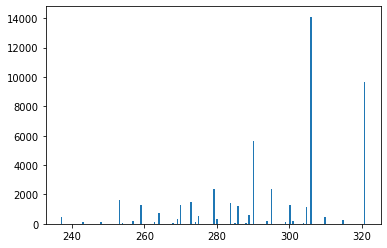

In [106]:
# Simulate it many times
bs = [ biden_sim() for _ in range(50000) ]
ts = [538-b for b in bs] # Trump electoral votes 
b_win = np.mean([b>=270 for b in bs])
print('Biden win probability is '+str(b_win))
import matplotlib.pyplot as plt
plt.hist(bs,bins=200)

t_win = np.mean([b<=268 for b in bs ])
tie = np.mean([b==269 for b in bs ])
print('Trump win probability is '+str(t_win))
print('Tie probability is '+ str(tie))
b270 = np.mean([b==270 for b in bs])
print('Biden=270 probability is '+str(b270))

In [107]:
# Compute inverse probabilities (European quoting convention) for range outcomes
prices = {'trump_270_299':1./np.mean([t>=270 and t<=299 for t in ts]),
          'trump_300_329':1./np.mean([t>=300 and t<=329 for t in ts]),
          'biden_270_299':1./np.mean([b>=270 and b<=299 for b in bs]),
          'biden_300_329':1./np.mean([b>=300 and b<=329 for b in bs])}
pprint(prices)

{'biden_270_299': 2.814681378068003,
 'biden_300_329': 1.8380325699371394,
 'trump_270_299': 11.627906976744187,
 'trump_300_329': 116.27906976744185}


In [108]:
# American quoting conventions
def pm(p):
   if p>0.5:
     return '-'+str(round(100*(p/(1-p)),0))
   else:
     return '+'+str(round(100/p - 100,0))
examples = {'p=0.33333':pm(0.333333),
            'p=0.75':pm(0.75)}
#pprint(examples)

prices = {'trump_270_or_more':pm(t_win),
          'biden_270_or_more':pm(b_win),
          'trump_270_299':pm(np.mean([t>=270 and t<=299 for t in ts])),
          'trump_300_329':pm(np.mean([t>=300 and t<=329 for t in ts])),
          'biden_270_299':pm(np.mean([b>=270 and b<=299 for b in bs])),
          'biden_300_329':pm(np.mean([b>=300 and b<=329 for b in bs]))}
pprint(prices)

{'biden_270_299': '+181.0',
 'biden_270_or_more': '-893.0',
 'biden_300_329': '-119.0',
 'trump_270_299': '+1063.0',
 'trump_270_or_more': '+957.0',
 'trump_300_329': '+11528.0'}
